In [1]:
!rm stan_utility.py

!wget https://raw.githubusercontent.com/betanalpha/jupyter_case_studies/master/pystan_workflow/stan_utility.py

--2019-07-23 09:18:03--  https://raw.githubusercontent.com/betanalpha/jupyter_case_studies/master/pystan_workflow/stan_utility.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5593 (5.5K) [text/plain]
Saving to: ‘stan_utility.py’

stan_utility.py     100%[===================>]   5.46K  --.-KB/s    in 0s      

2019-07-23 09:18:03 (12.2 MB/s) - ‘stan_utility.py’ saved [5593/5593]



In [2]:
%matplotlib inline

import random
random.seed(123)

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import importlib

In [3]:
import pystan
import stan_utility

import survivalstan

## SurvivalStan - Exponential Model

Tutorial:
http://www.hammerlab.org/2017/06/26/introducing-survivalstan/

### Model 1: Exponential model with no covariates

$S(t) = exp(-a \cdot t)$

$a \sim N(0,1)$

,true_t,t,event,sex,age,index,event_fac
0,2.132717,2.132717,True,female,45,0,1
1,0.382696,0.382696,True,male,53,1,1
2,1.239084,1.239084,True,male,53,2,1
3,7.842704,7.842704,True,female,53,3,1
4,1.323792,1.323792,True,male,46,4,1


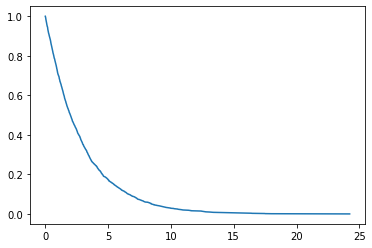

In [116]:
# Data
df1 = survivalstan.sim.sim_data_exp(censor_time = 50, 
                                    N = 2000, 
                                    rate = 0.35)

df1['event_fac'] = df1['event'].apply(lambda x: 1 if x == True else 0)

data1 = dict(N = len(df1),
            y = df1['t'],
            event = df1['event_fac'])

survivalstan.utils.plot_observed_survival(df1, time_col='t', event_col='event')

df1.head(n = 5)

In [98]:
# Compile model
model = stan_utility.compile_model('exp.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_197c015df38c6c923591a164314f576a NOW.


In [117]:
# Infer parameters
Niter = 10000
Nchains = 2

ctrl = {'max_treedepth': 20,
        'adapt_delta': 0.99}

fit = model.sampling(data = data1, 
                     chains = Nchains,
                     iter = Niter,
                     control = ctrl,
                     seed = 194838)

In [119]:
pystan.check_hmc_diagnostics(fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [120]:
fit

Inference for Stan model: anon_model_197c015df38c6c923591a164314f576a.
2 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=10000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   0.35  1.7e-4 7.9e-3   0.33   0.34   0.35   0.35   0.36   2065    1.0
lp__   -4114    0.02   0.71  -4116  -4114  -4114  -4114  -4113   1804    1.0

Samples were drawn using NUTS at Tue Jul 23 11:38:10 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [90]:
# Model org
fit_org = survivalstan.fit_stan_survival_model(
    df=df1,
    time_col='t',
    event_col='event',
    model_code=survivalstan.models.exp_survival_model,
    formula='~ 1',
    model_cohort = 'exp model'
)

Reusing model.


Ran in 19.807 sec.


In [93]:
sfit_org = fit_org['fit']

In [95]:
fit1

{'df':      event_status       time  Intercept
 0               1   2.225285        1.0
 1               1   1.394729        1.0
 2               1   5.975046        1.0
 3               1   5.668242        1.0
 4               1  13.302080        1.0
 ..            ...        ...        ...
 195             1   3.766630        1.0
 196             1   1.404374        1.0
 197             1   9.087744        1.0
 198             1  26.227718        1.0
 199             1   4.078527        1.0
 
 [200 rows x 3 columns], 'x_df':      Intercept
 0          1.0
 1          1.0
 2          1.0
 3          1.0
 4          1.0
 ..         ...
 195        1.0
 196        1.0
 197        1.0
 198        1.0
 199        1.0
 
 [200 rows x 1 columns], 'x_names': Index(['Intercept'], dtype='object'), 'data': {'y': array([ 2.22528464,  1.39472911,  5.97504589,  5.66824215, 13.30208004,
          0.32959294,  5.11796927, 28.71497977,  6.63352924, 26.59232101,
          0.23216121,  6.78346453,  4.63

In [71]:
# Simulate data
# Model: exp(-3*t) * exp(0.5*sex)

# Sim
df2 = survivalstan.sim.sim_data_exp_correlated(
    N=500, censor_time=20, rate_form='1 + sex', rate_coefs=[-3, 0.5])

# Replace strings
df2['sex_fac'] = df2['sex'].apply(lambda x: 1 if x == 'male' else 0)
df2['event_fac'] = df2['event'].apply(lambda x: 1 if x == 'True' else 0)

# Write to file
df2.to_csv('exp.dat')

# Prepare data input
x = df2[['age', 'sex_fac']].to_numpy()

data = dict(N = len(df2),
            M = 2,
            x = x,
            y = df2['t'],
            event = df2['event_fac'])

In [72]:
df2.head()

,sex,age,rate,true_t,t,event,index,sex_fac,event_fac
0,male,63,0.082085,15.855396,15.855396,True,0,1,0
1,female,51,0.049787,5.354489,5.354489,True,1,0,0
2,male,47,0.082085,6.303516,6.303516,True,2,1,0
3,female,54,0.049787,39.246327,20.000000,False,3,0,0
4,male,47,0.082085,39.279712,20.000000,False,4,1,0


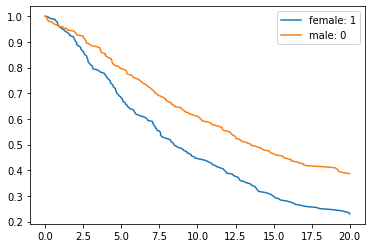

In [73]:
survivalstan.utils.plot_observed_survival(
    df2.query('sex_fac == 1'),
    time_col='t',
    event_col='event_fac',
    label='female: 1')

survivalstan.utils.plot_observed_survival(
    df2.query('sex_fac == 0'),
    time_col='t',
    event_col='event_fac',
    label='male: 0')

plt.legend()

In [58]:
# Model used
src_model = survivalstan.models.exp_survival_model

with open('exp.stan', 'w') as myf:
    print(src_model, file = myf)
    
print(src_model)

functions {
  vector sqrt_vec(vector x) {
    vector[dims(x)[1]] res;

    for (m in 1:dims(x)[1]){
      res[m] = sqrt(x[m]);
    }

    return res;
  }

  vector bg_prior_lp(real r_global, vector r_local) {
    r_global ~ normal(0.0, 10.0);
    r_local ~ inv_chi_square(1.0);

    return r_global * sqrt_vec(r_local);
  }
}
data {
  // dimensions
  int<lower=0> N;             // number of observations
  int<lower=1> M;             // number of predictors
  
  // observations
  matrix[N, M] x;             // predictors for observation n
  vector[N] y;                // time for observation n
  vector[N] event;            // event status (1:event, 0:censor) for obs n
}
parameters {
  real<lower=0> tau_s_raw;
  vector<lower=0>[M] tau_raw;
  vector[M] beta_raw;
  real<lower=0> alpha;
}
transformed parameters {
  vector[M] beta;
  vector[N] lp;

  beta = bg_prior_lp(tau_s_raw, tau_raw) .* beta_raw;
  for (n in 1:N) {
    lp[n] = exp(dot_product(x[n], beta));
  }
}
model {
  // priors
  targ

In [22]:
# Compile model
model = stan_utility.compile_model('exp.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_91316d735f21b5036c0bdb7c109cc12d NOW.


In [74]:
# Infer parameters
Niter = 10000
Nchains = 2

ctrl = {'max_treedepth': 20,
        'adapt_delta': 0.99}

fit = model.sampling(data = data, 
                     chains = Nchains,
                     iter = Niter,
                     # warmup = 9000,
                     control = ctrl,
                     seed=194838)

pystan.check_hmc_diagnostics(fit)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


{'n_eff': False,
 'Rhat': False,
 'divergence': False,
 'treedepth': True,
 'energy': False}

In [75]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_91316d735f21b5036c0bdb7c109cc12d.
2 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=10000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
tau_s_raw     5.71    0.09   3.49   0.75   4.79    5.3    5.3   15.7   1398   1.01
tau_raw[1]   12.81    7.05  93.01   0.24   0.78   0.78   1.35  38.63    174   1.03
tau_raw[2]   55.75   18.74 689.95   0.26   0.84   0.84   1.79 177.23   1355    1.0
beta_raw[1]-7.1e-3    0.66   0.71   -1.6  -0.52   0.31   0.62   0.62      1   2.33
beta_raw[2]  -0.61    0.68   0.92  -1.57  -1.21  -1.21  -0.01   1.66      2   1.42
alpha         1.16    0.42   0.56   0.06   0.67   1.52   1.52   1.92      2   1.43
beta[1]      -0.34    3.41   3.71  -8.38  -3.03    1.4   2.88   2.92      1   2.28
beta[2]      -4.25    0.54  22.77 -37.42  -5.89  -5.89  -0.05  22.76   1777    1.0
lp[1]       5.4e76  6.

In [78]:
# Infer parameters
fit1 = survivalstan.fit_stan_survival_model(
    df=df2,
    time_col='t',
    event_col='event',
    model_code=survivalstan.models.exp_survival_model,
    formula='~ age + sex',
    model_cohort = 'exp model',
    iter = Niter,
    chains = Nchains,    
    seed = 194838
)

Reusing model.


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Ran in 166.092 sec.


In [81]:
sfit1 = fit1['fit']
sfit1


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_0176fed484efbd961d78e8973c25ff98.
2 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=10000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
tau_s_raw     0.34    0.08   0.23   0.02   0.15   0.33   0.48   0.86      7   1.11
tau_raw[1]  376.59  161.21  1.2e4   0.21   0.46   1.66   8.39 575.78   5444    1.0
tau_raw[2]    1.53    0.18   3.26   0.14   0.36   0.77   2.25   4.55    344   1.01
beta_raw[1]   1.06    0.03   0.51   0.22   0.65   1.13   1.28    2.3    308   1.01
beta_raw[2]   0.03  4.5e-3   0.14  -0.12-4.8e-3 1.9e-3   0.03   0.34    969   1.01
alpha         0.05  1.9e-3   0.02   0.02   0.03   0.05   0.06   0.09     85   1.02
beta[1]       0.39    0.01   0.11   0.16   0.33   0.39   0.47   0.61     57   1.04
beta[2]     2.2e-3  9.9e-4 6.9e-3-9.9e-3-3.0e-3 8.6e-4 6.9e-3   0.02     49   1.03
lp[1]         1.89    

In [79]:
fit2 = survivalstan.fit_stan_survival_model(
    df=df2,
    time_col='t',
    event_col='event_fac',
    model_code=survivalstan.models.exp_survival_model,
    formula='~ age + sex_fac',
    model_cohort = 'exp model fac',
    iter = Niter,
    chains = Nchains,    
    seed = 194838
)

Reusing model.


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Ran in 55.003 sec.


In [82]:
sfit2 = fit2['fit']



For the full summary use 'print(fit)'

Inference for Stan model: anon_model_0176fed484efbd961d78e8973c25ff98.
2 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=10000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
tau_s_raw     5.97    0.16   4.88   0.32   2.22   4.75   8.46  18.14    941    1.0
tau_raw[1]    8.32    1.61   78.2   0.18   0.53   1.21   3.25  42.94   2345    1.0
tau_raw[2]   81.95   31.16 2252.7   0.19    0.7   1.96   7.54 340.74   5226    1.0
beta_raw[1]  -0.68    0.02   0.52  -1.96  -0.95  -0.56  -0.28  -0.05    589    1.0
beta_raw[2]  -0.04    0.03   1.02  -2.07   -0.7  -0.02   0.63   1.97   1450    1.0
alpha         0.81    0.01   0.61   0.03   0.32   0.69   1.18   2.21   1972    1.0
beta[1]       -3.4    0.06   2.55  -8.81  -5.23  -2.83  -1.18  -0.24   1785    1.0
beta[2]      -2.03    0.98  31.29 -59.55  -4.66  -0.05   3.45  42.72   1026    1.0
lp[1]       9.0e-7  2.

In [77]:
# Some results
survivalstan.utils.filter_stan_summary([fit1], pars=['lp__','beta'])

survivalstan.utils.plot_coefs([fit1, fit2])

NameError: name 'fit2' is not defined

In [69]:
pystan.check_hmc_diagnostics(fit1['fit'])

{'n_eff': True,
 'Rhat': False,
 'divergence': False,
 'treedepth': False,
 'energy': True}

In [15]:
# Diagnostics - tutorial


,mean,se_mean,sd,2.5%,50%,97.5%,Rhat
lp__,-1380.831248,0.184798,2.527832,-1386.828028,-1380.392029,-1377.426718,1.012229
beta[1],0.369574,0.004876,0.109217,0.146884,0.374531,0.569993,1.001107
beta[2],-0.004035,0.000319,0.006614,-0.017575,-0.004285,0.008706,1.009214


In [8]:
# Diagnostics
# http://mc-stan.org/users/documentation/case-studies/pystan_workflow.html

sfit1 = fit1['fit']
stan_utility.check_all_diagnostics(sfit1)

n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters
212.0 of 2000 iterations ended with a divergence (10.6%)
  Try running with larger adapt_delta to remove the divergences
0 of 2000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior


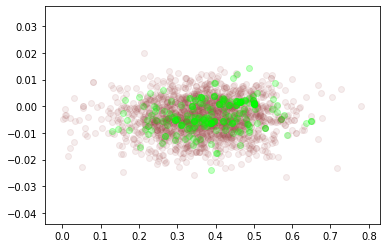

In [9]:
light="#DCBCBC"
light_highlight="#C79999"
mid="#B97C7C"
mid_highlight="#A25050"
dark="#8F2727"
dark_highlight="#7C0000"
green="#00FF00"

nondiv_params, div_params = stan_utility.partition_div(sfit1)

plt.scatter([x[0] for x in nondiv_params['beta']], [x[1] for x in nondiv_params['beta']], 
             color = mid_highlight, alpha=0.1)

plt.scatter([x[0] for x in div_params['beta']], [x[1] for x in div_params['beta']], 
             color = green, alpha=0.25)